In [16]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report

VideoName = "2"

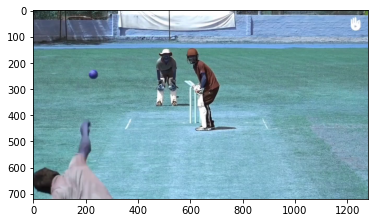

In [21]:
frames = [f for f in os.listdir('frames/') if f.split(".")[0].isnumeric()]
frames.sort(key=lambda f: int(f.split(".")[0]))

images=[]
for i in frames:
    image = cv2.imread('frames/'+i)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    images.append(image)
images=np.array(images)

frame= cv2.imread('frames/' + frames[75])
plt.imshow(frame)

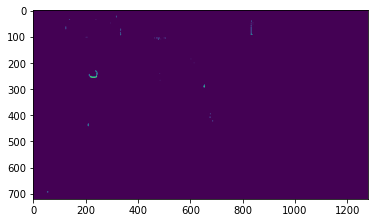

In [22]:

hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
lower_red =  np.array([5,135,10])
upper_red = np.array([10, 200, 255])
mask = cv2.inRange(hsv, lower_red, upper_red)
plt.imshow(mask)

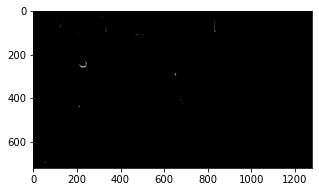

In [18]:
_ , mask = cv2.threshold(mask, 10, 50, cv2.THRESH_BINARY)
plt.figure(figsize=(5,5))
plt.imshow(mask,cmap='gray')

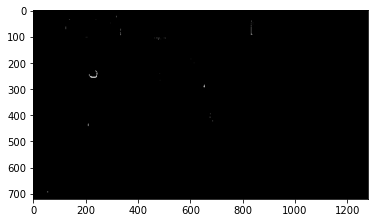

In [19]:
image , contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
plt.imshow(image,cmap='gray')

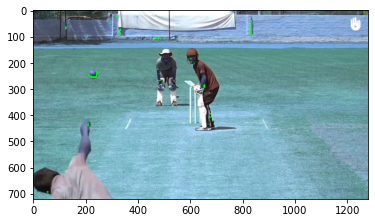

In [20]:
img_copy = np.copy(frame)
cv2.drawContours(img_copy, contours, -1, (0,255,0), 3)
plt.imshow(img_copy)

In [23]:
!rm -r patch/*
num=20
cnt=0
for i in range(len(contours)):
    x,y,w,h = cv2.boundingRect(contours[i])
    if(x>=num and y>=num):
        xmin, ymin= x-num, y-num
        xmax, ymax= x+w+num, y+h+num
    else:
        xmin, ymin=x, y
        xmax, ymax=x+w, y+h
    cv2.imwrite("patch/"+str(cnt)+".png",frame[ymin:ymax,xmin:xmax])
    cnt=cnt+1

zsh:1: no matches found: patch/*


In [7]:
folders=os.listdir('data/')
images=[]
labels= []
for folder in folders[1:]:
    try:
        files= os.listdir('data/'+folder)
    except Exception as e:
            print(e)
    for file in files:
        try:
            img=cv2.imread('data/'+folder+'/'+file,1)
            img=cv2.resize(img,(25,25))
            images.append(img)
            labels.append(int(folder))
        except Exception as e:
            print(e)
images = np.array(images)
features = images.reshape(len(images),-1)

OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [8]:
x_tr,x_val,y_tr,y_val = train_test_split(features,labels, test_size=0.2, stratify=labels,random_state=0)

rfc = RandomForestClassifier(max_depth=3) 
rfc.fit(x_tr,y_tr)

y_pred = rfc.predict(x_val)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       324
           1       0.98      0.95      0.97       132

    accuracy                           0.98       456
   macro avg       0.98      0.97      0.98       456
weighted avg       0.98      0.98      0.98       456



In [9]:
!rm -r ball/*
ball_df = pd.DataFrame(columns=['frame','x','y','w','h'])

for idx in range(len(frames)):
    print(idx)
    img= cv2.imread('frames/' + frames[idx])
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # lower_red =  np.array([5,130,10])
    # upper_red = np.array([10, 200, 255])    
    lower_red =  np.array([0,130,60])
    upper_red = np.array([8, 220, 255])
    mask = cv2.inRange(hsv, lower_red, upper_red)
   
    image, contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    !rm -r patch/*

    num=20
    cnt=0
    df = pd.DataFrame(columns=['frame','x','y','w','h'])
    
    #creating patches
    for i in range(len(contours)):

        x,y,w,h = cv2.boundingRect(contours[i])

        if(x>=num and y>=num):
            xmin, ymin= x-num, y-num
            xmax, ymax= x+w+num, y+h+num
        else:
            xmin, ymin= x,y
            xmax, ymax= x+w, y+h

        df.loc[cnt,'frame'] = frames[idx]
        df.loc[cnt,'x']=x
        df.loc[cnt,'y']=y
        df.loc[cnt,'w']=w
        df.loc[cnt,'h']=h
        
        cv2.imwrite("patch/"+str(cnt)+".png",img[ymin:ymax,xmin:xmax])

        #for Debugging
        # try:
        #     os.makedirs("patch_temp/"+str(frames[idx]))
        # except OSError as e:
        #     pass
        #     # print(e)
        # cv2.imwrite("patch_temp/"+str(frames[idx])+"/"+str(cnt)+".png",img[ymin:ymax,xmin:xmax])

        cnt=cnt+1
    
    files = [f for f in os.listdir('patch/') if f.split(".")[0].isnumeric()]
    if(len(files)>0):
        files.sort(key=lambda f: int(f.split(".")[0]))

        test=[]
        for file in files:
            img=cv2.imread('patch/'+file,1)
            img=cv2.resize(img,(25,25))
            test.append(img)

        test = np.array(test)

        test = test.reshape(len(test),-1)
        y_pred = rfc.predict(test)
        prob=rfc.predict_proba(test)
        if 0 in y_pred:
            ind = np.where(y_pred==0)[0]
            proba = prob[:,0]
            print(proba[ind])
           
            confidence = proba[ind]
            confidence = [i for i in confidence if i>0.7]
            if(len(confidence)>0):

                maximum = max(confidence)
                ball_file=files[list(proba).index(maximum)]

                img= cv2.imread('patch/'+ball_file)
                cv2.imwrite('ball/'+str(frames[idx]),img)

                no = int(ball_file.split(".")[0])
                ball_df.loc[idx]= df.loc[no]
            else:
                ball_df.loc[idx,'frame']=frames[idx]

        else:
            ball_df.loc[idx,'frame']=frames[idx]
ball_df.dropna(inplace=True)
print(ball_df)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
[0.51082254]
30
31
32
33
34
35
36
37
[0.51249538]
38
[0.51249538]
39
[0.50707776]
40
[0.5288031  0.51059397]
41
42
[0.93097768 0.51481638]
43
[0.51794419]
44
[0.909375   0.83961998 0.5137331 ]
45
46
[0.50064922 0.69068287 0.79327543]
47
[0.72040569]
48
[0.94266213]
49
[0.92339844 0.90549706]
50
[0.92339844 0.90986291]
51
[0.9443062]
52
[0.92660614 0.95829066]
53
[0.95100511 0.92773084]
54
[0.81253131 0.94542701 0.92898472 0.95774883 0.87145746]
55
[0.95025388 0.96023144]
56
[0.95025388]
57
[0.94046769 0.85283708 0.87105383 0.8930391  0.76276707]
58
[0.85751985 0.9465616  0.79630437]
59
[0.67220819]
60
[0.93748834 0.9362861  0.71435393 0.90783982]
61
[0.82786647 0.96193301 0.76240318]
62
[0.82786647 0.96193301 0.76240318]
63
[0.60886991 0.89915604 0.66453857 0.75643115 0.95401344 0.73502604
 0.82654646]
64
65
[0.68211972]
66
[0.66233211]
67
[0.62603358]
68
[0.62603358]
69
[0.53344229]
70
71
[0.56333389]
72
[

In [10]:

files = ball_df['frame'].values
done=[]
mapper = [int(f.split(".")[0]) for f in ball_df['frame'].values]

framesAll = [f for f in os.listdir('frames/') if f.split(".")[0].isnumeric()]
framesAll.sort(key=lambda f: int(f.split(".")[0]))
num=10
for idx in range(len(framesAll)):
    #draw contours 
    img = cv2.imread('frames/'+framesAll[idx])
    
    for index in range(len(done)-1):
        traj,traj1=done[index],done[index+1]
        x,x1=traj[0],traj1[0]
        y,y1=traj[1],traj1[1]
        w,w1=traj[2],traj1[2]
        h,h1=traj[3],traj1[3]
        
        cv2.line(img, (int(x+(w/2)), int(y+(h/2))),(int(x1+(w1/2)), int(y1+(h1/2))),  (255,0,0), 1)
        cv2.circle(img, (int(x+(w/2)), int(y+(h/2))),2,  (255,0,0), 5)

    if framesAll[idx] in files:
        x=ball_df.loc[int(framesAll[idx].split(".")[0]),'x']
        y=ball_df.loc[int(framesAll[idx].split(".")[0]),'y']
        w=ball_df.loc[int(framesAll[idx].split(".")[0]),'w']
        h=ball_df.loc[int(framesAll[idx].split(".")[0]),'h']
        
        xmin=x-num
        ymin=y-num
        xmax=x+w+num
        ymax=y+h+num

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255,0,0), 2)
        done.append([x,y,w,h])
    cv2.imwrite("frames/"+framesAll[idx],img)       

In [11]:

frames = [f for f in os.listdir('frames/') if f.split(".")[0].isnumeric()]
frames.sort(key=lambda f: int(f.split(".")[0]))

frame_array=[]

for i in range(len(frames)):
    img = cv2.imread('frames/'+frames[i])
    height, width, layers = img.shape
    size = (width,height)
    frame_array.append(img)


out = cv2.VideoWriter(VideoName+'_Marked'+'.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 25, size)
#Creating the final video from the updated frames
for i in range(len(frame_array)):
    out.write(frame_array[i])
out.release()